In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D, GRU
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation, UpSampling1D
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling1D

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from keras import  backend as K

2024-05-23 17:42:41.591173: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 17:42:41.591255: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 17:42:41.591282: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 17:42:41.599009: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [9]:
from sklearn.preprocessing import StandardScaler

def scale_data(trainX, testX):
 # remove overlap
 cut = int(trainX.shape[1] / 2)
 longX = trainX[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 # flatten train and test
 flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
 flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

 s = StandardScaler()
 # fit on training data
 s.fit(longX)
 # apply to training and test data
 longX = s.transform(longX)
 flatTrainX = s.transform(flatTrainX)
 flatTestX = s.transform(flatTestX)
 # reshape
 flatTrainX = flatTrainX.reshape((trainX.shape))
 flatTestX = flatTestX.reshape((testX.shape))
 return flatTrainX, flatTestX

In [10]:
trainX, testX = scale_data(trainX, testX)

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [12]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

In [13]:
n_classes = 6

In [14]:
def CNN_BiGRU(x, units, dropout=0):
    # 첫 번째 레이어: 1D 합성곱
    x = layers.Conv1D(filters=units, kernel_size=3, activation="relu", padding = 'same')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # 두 번째 레이어: 양방향 GRU
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True, activation=None))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)    
    return x

In [15]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Transformer Encoder Part
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part using CNN and BiGRU
    x = CNN_BiGRU(res, ff_dim, dropout)
    x = layers.Dense(inputs.shape[-1])(x)  # 입력 텐서와 차원을 맞추기 위해 Dense 레이어 추가
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [16]:
"""
The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.
"""


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    # input_shape 튜플 풀기
    n_steps, n_features = input_shape
    
    inputs = keras.Input(shape=(n_steps, n_features))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [17]:
"""
## Train and evaluate
"""

input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

2024-05-23 17:42:49.174219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1159 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:88:00.0, compute capability: 8.0
2024-05-23 17:42:49.176592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38284 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0
2024-05-23 17:42:50.781995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 1.13GiB (1215299584 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-05-23 17:42:50.808467: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 1.02GiB (1093769728 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-05-23 17:42:50.814064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 938

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 9)]             0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 128, 9)               39945     ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 9)               0         ['multi_head_attention[0][0]']
                                                                                                  
 layer_normalization (Layer  (None, 128, 9)               18        ['dropout[0][0]']         

 tf.__operators__.add_3 (TF  (None, 128, 9)               0         ['layer_normalization_7[0][0]'
 OpLambda)                                                          , 'tf.__operators__.add_2[0][0
                                                                    ]']                           
                                                                                                  
 global_average_pooling1d (  (None, 128)                  0         ['tf.__operators__.add_3[0][0]
 GlobalAveragePooling1D)                                            ']                            
                                                                                                  
 dense_2 (Dense)             (None, 128)                  16512     ['global_average_pooling1d[0][
                                                                    0]']                          
                                                                                                  
 dropout_6

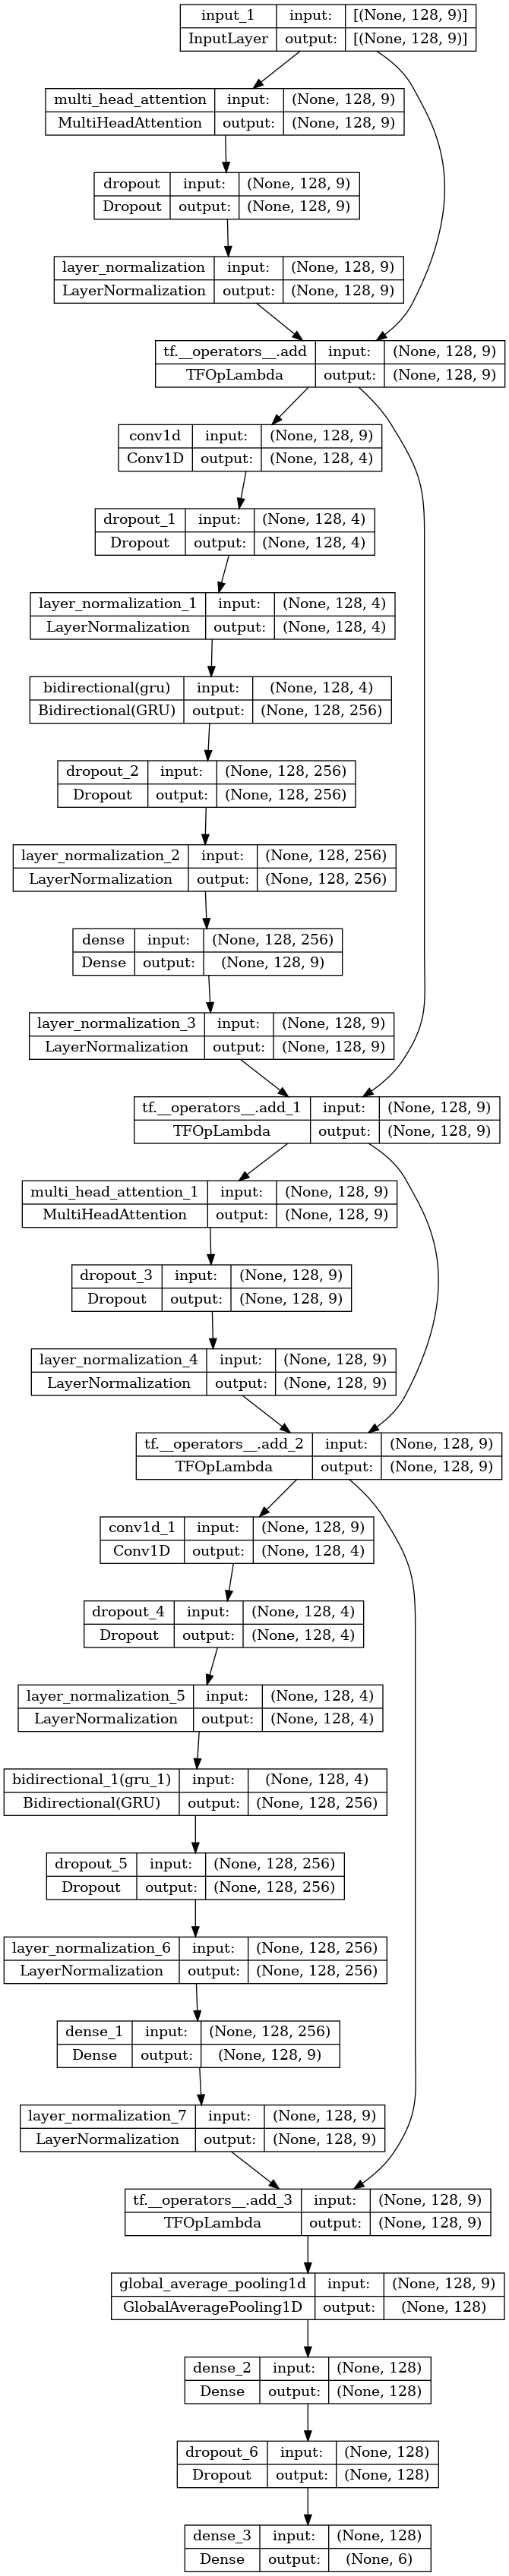

In [18]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [19]:
history = model.fit(
    X_train,
    y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
)

model.evaluate(testX, testy_one_hot, verbose=1)

Epoch 1/50


2024-05-23 17:43:01.381066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-05-23 17:43:02.011038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 398.58MiB (417941248 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-05-23 17:43:02.011095: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 308.39MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 17:43:02.256202: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f95eb5082f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-23 17:43:02.256246: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-05-23 17:43:02.256253: I tensorflow/compiler

 1/81 [..............................] - ETA: 20:17 - loss: 1.9536 - accuracy: 0.2500

2024-05-23 17:43:07.909870: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 419.38MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 2/81 [..............................] - ETA: 1:17 - loss: 1.9306 - accuracy: 0.2422 

2024-05-23 17:43:08.156619: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 419.38MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


81/81 [==============================] - 96s 1s/step - loss: 1.7609 - accuracy: 0.2794 - val_loss: 1.6365 - val_accuracy: 0.3318
Epoch 2/50
81/81 [==============================] - 81s 995ms/step - loss: 1.5588 - accuracy: 0.3480 - val_loss: 1.4652 - val_accuracy: 0.3885
Epoch 3/50
81/81 [==============================] - 81s 1000ms/step - loss: 1.4261 - accuracy: 0.4129 - val_loss: 1.3588 - val_accuracy: 0.4891
Epoch 4/50
81/81 [==============================] - 82s 1s/step - loss: 1.3426 - accuracy: 0.4679 - val_loss: 1.2886 - val_accuracy: 0.5453
Epoch 5/50
81/81 [==============================] - 81s 996ms/step - loss: 1.2818 - accuracy: 0.5010 - val_loss: 1.2342 - val_accuracy: 0.5635
Epoch 6/50
81/81 [==============================] - 82s 1s/step - loss: 1.2250 - accuracy: 0.5429 - val_loss: 1.1876 - val_accuracy: 0.5861
Epoch 7/50
81/81 [==============================] - 82s 1s/step - loss: 1.1806 - accuracy: 0.5589 - val_loss: 1.1418 - val_accuracy: 0.6097
Epoch 8/50
81/81 [===

[0.4557744264602661, 0.8517135977745056]

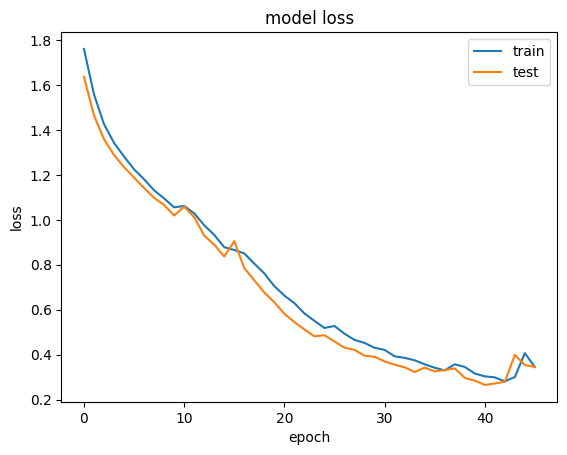

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

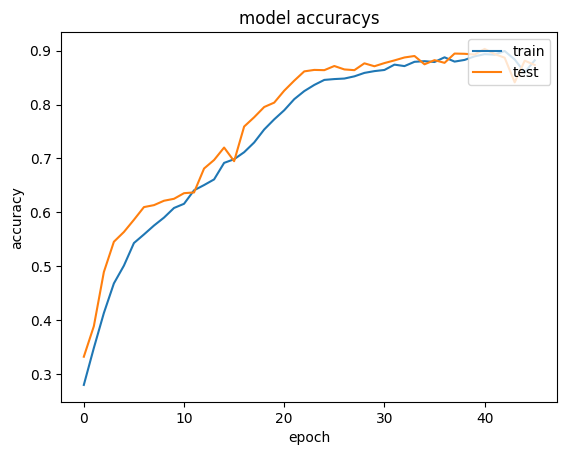

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracys')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

93/93 [==============================] - 11s 106ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

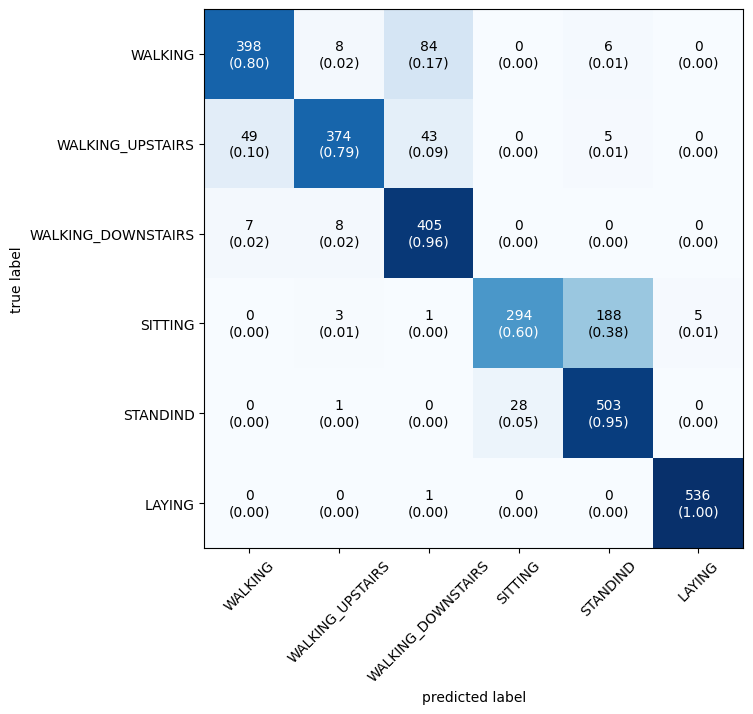

In [22]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

In [23]:
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))

[[398   8  84   0   6   0]
 [ 49 374  43   0   5   0]
 [  7   8 405   0   0   0]
 [  0   3   1 294 188   5]
 [  0   1   0  28 503   0]
 [  0   0   1   0   0 536]]
0.8517136070580251
0.8491084478412741
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       496
           1       0.95      0.79      0.86       471
           2       0.76      0.96      0.85       420
           3       0.91      0.60      0.72       491
           4       0.72      0.95      0.82       532
           5       0.99      1.00      0.99       537

    accuracy                           0.85      2947
   macro avg       0.87      0.85      0.85      2947
weighted avg       0.87      0.85      0.85      2947

